# Kuala Lumpur Weather Prediction using FB Prophet and 10 Years Historical Data

## Install and Import Dependencies

In [2]:
import pandas as pd
import numpy as np
import chart_studio.plotly as plotly
import plotly.figure_factory as ff
from plotly import graph_objs as go
from matplotlib import pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import pystan
import pickle

## Read in Data and Process Dataset

#### Defining the dataset

In [3]:
old_df = pd.read_csv('Kuala+Lumpur.csv')
old_df.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2012-03-08,32,22,0.0,8.8,6,98,07:20 PM,06:54 AM,07:22 AM,...,7,44,80,4.1,1006,32,10,192,5,Kuala+Lumpur
1,2012-03-09,33,22,0.0,11.6,6,91,08:14 PM,07:45 AM,07:22 AM,...,8,45,75,4.1,1006,33,9,272,6,Kuala+Lumpur
2,2012-03-10,32,22,0.0,10.2,6,84,09:10 PM,08:36 AM,07:21 AM,...,6,59,81,6.3,1007,32,9,270,4,Kuala+Lumpur
3,2012-03-11,31,23,0.0,6.0,6,77,10:07 PM,09:31 AM,07:21 AM,...,7,61,86,8.3,1008,31,8,97,4,Kuala+Lumpur
4,2012-03-12,26,22,0.0,7.4,5,71,11:06 PM,10:27 AM,07:21 AM,...,9,74,94,5.0,1010,26,6,45,6,Kuala+Lumpur


#### Check for data types and any null values

In [33]:
old_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_time          3653 non-null   object 
 1   maxtempC           3653 non-null   int64  
 2   mintempC           3653 non-null   int64  
 3   totalSnow_cm       3653 non-null   float64
 4   sunHour            3653 non-null   float64
 5   uvIndex            3653 non-null   int64  
 6   moon_illumination  3653 non-null   int64  
 7   moonrise           3653 non-null   object 
 8   moonset            3653 non-null   object 
 9   sunrise            3653 non-null   object 
 10  sunset             3653 non-null   object 
 11  DewPointC          3653 non-null   int64  
 12  FeelsLikeC         3653 non-null   int64  
 13  HeatIndexC         3653 non-null   int64  
 14  WindChillC         3653 non-null   int64  
 15  WindGustKmph       3653 non-null   int64  
 16  cloudcover         3653 

In [34]:
# Handle Missing Values
old_df.isnull().sum()*100/len(df)

date_time            0.0
maxtempC             0.0
mintempC             0.0
totalSnow_cm         0.0
sunHour              0.0
uvIndex              0.0
moon_illumination    0.0
moonrise             0.0
moonset              0.0
sunrise              0.0
sunset               0.0
DewPointC            0.0
FeelsLikeC           0.0
HeatIndexC           0.0
WindChillC           0.0
WindGustKmph         0.0
cloudcover           0.0
humidity             0.0
precipMM             0.0
pressure             0.0
tempC                0.0
visibility           0.0
winddirDegree        0.0
windspeedKmph        0.0
location             0.0
dtype: float64

#### Drop unused columns

It is very unlikely that Kuala Lumpur to experience any form of snow formation, hence the "totalSnow_cm" column is dropped from the dataframe

In [4]:
df = old_df.drop(['totalSnow_cm'], axis = 1)

#### Identifying the scale of measurement used

In [5]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 18
Discrete feature Count 13
Continuous feature Count 5
Categorical feature Count 6


In [6]:
print(numerical_feature)

['maxtempC', 'mintempC', 'sunHour', 'uvIndex', 'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']


### Correlation between data

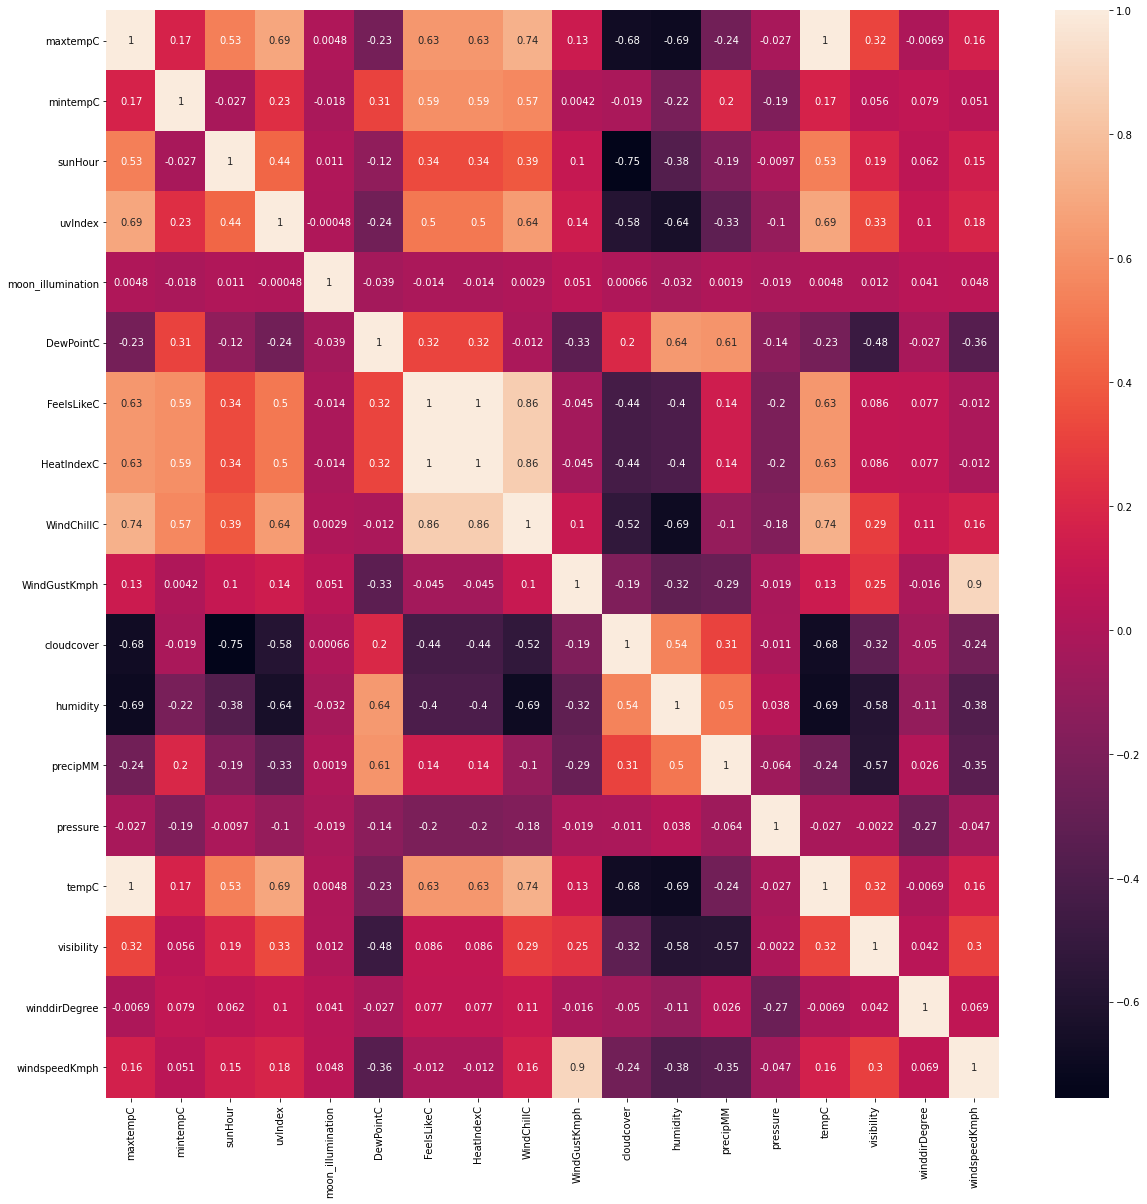

In [7]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

It can be observed that several variable such as WindChillC, FeelsLikeC and HeatIndexC, uvIndex and tempC, as well as WindGustKmph and windspeedKmph have strong positive correlation. In general, a pearson correlation of more than 0.7 indicates that there is a presence of multi-collinearity.

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


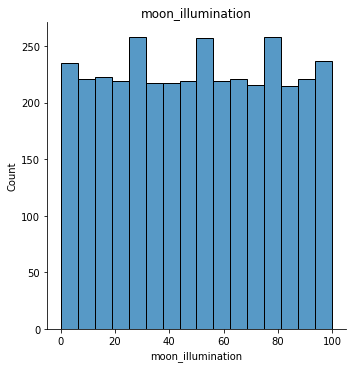

<Figure size 1080x1080 with 0 Axes>

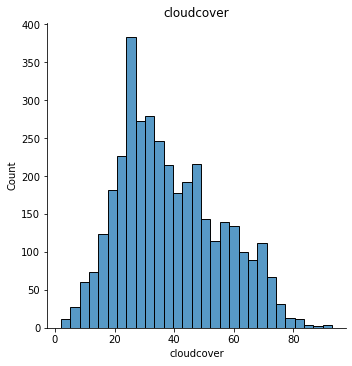

<Figure size 1080x1080 with 0 Axes>

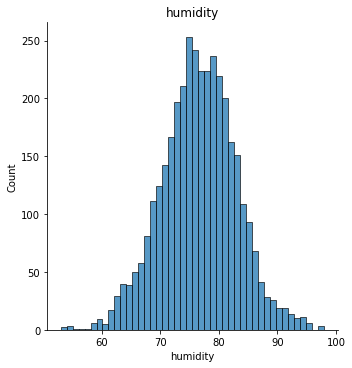

<Figure size 1080x1080 with 0 Axes>

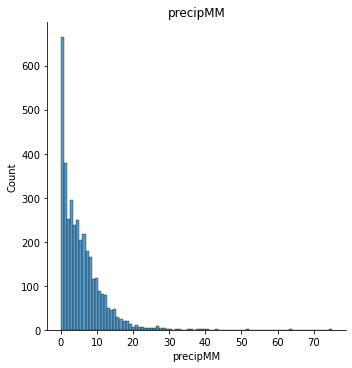

<Figure size 1080x1080 with 0 Axes>

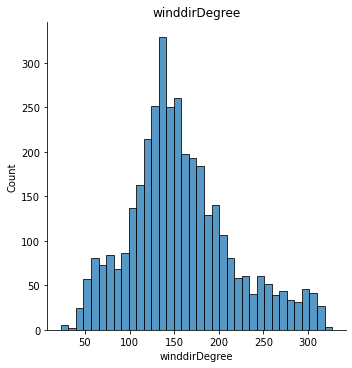

<Figure size 1080x1080 with 0 Axes>

In [8]:
for feature in continuous_feature:
    data=df.copy()
    sns.displot(df[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

It can be observed that the humidity for Kuala Lumpur is reaches its peak between 70 and 80, which means that the area is quite humid potentially due to the amount of precipitation that it receives on a regular basis, despite the volume of precipitation mainly hovering within the 0 to 10 mm region.

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarn

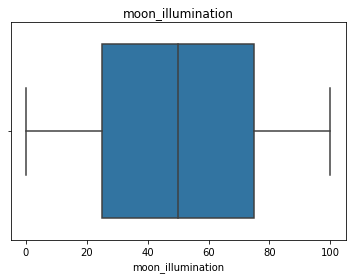

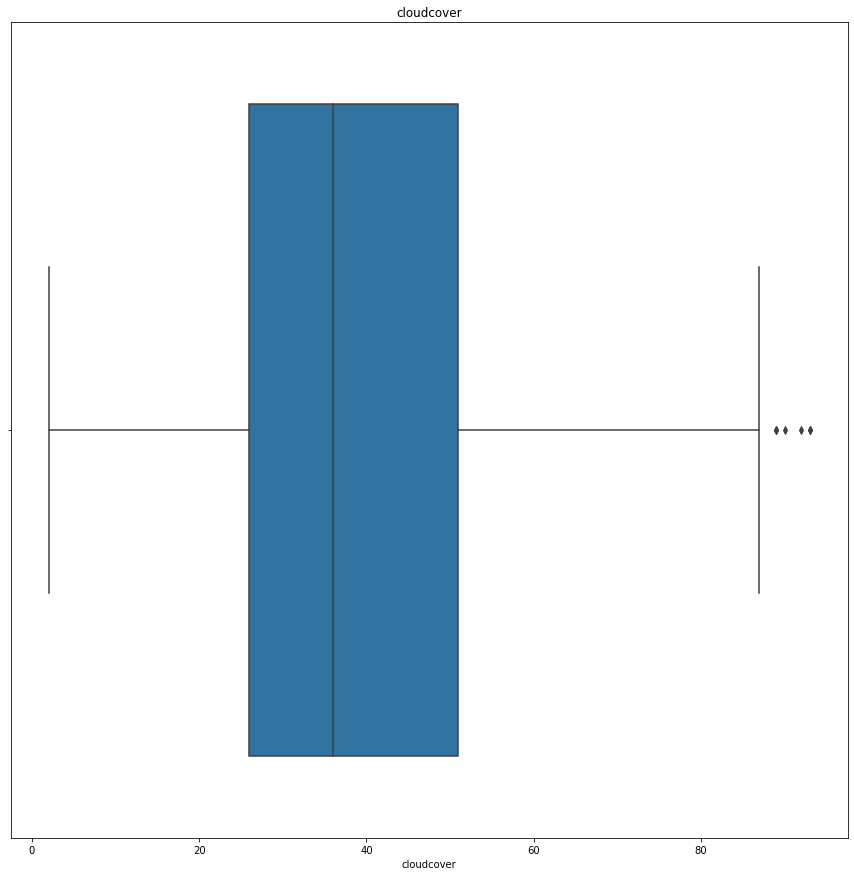

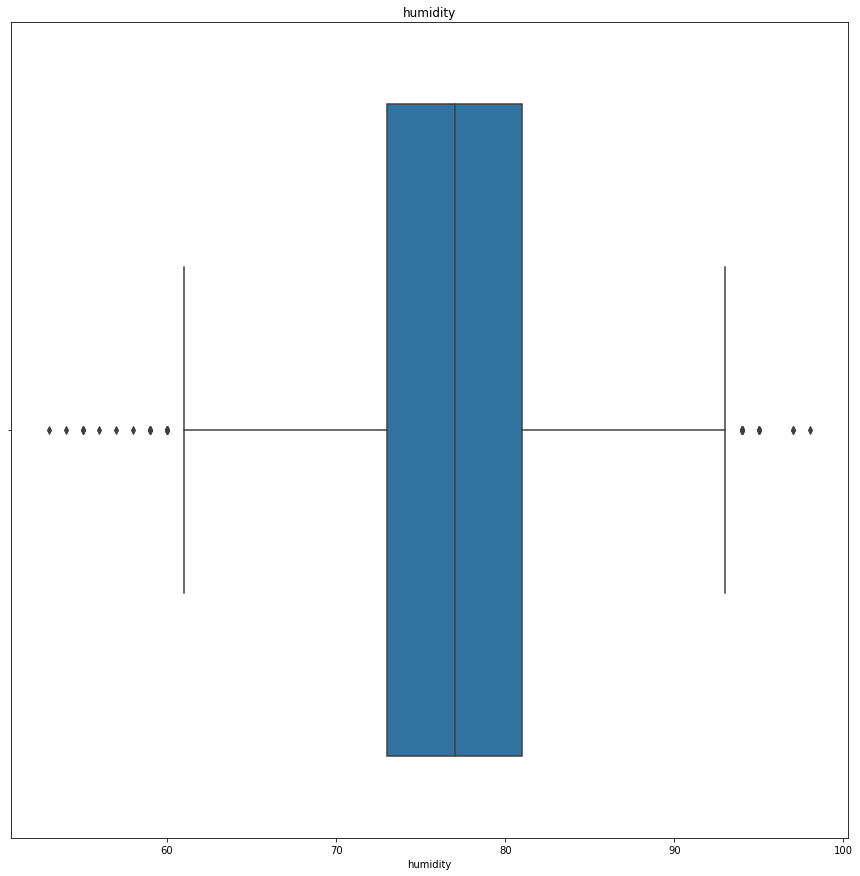

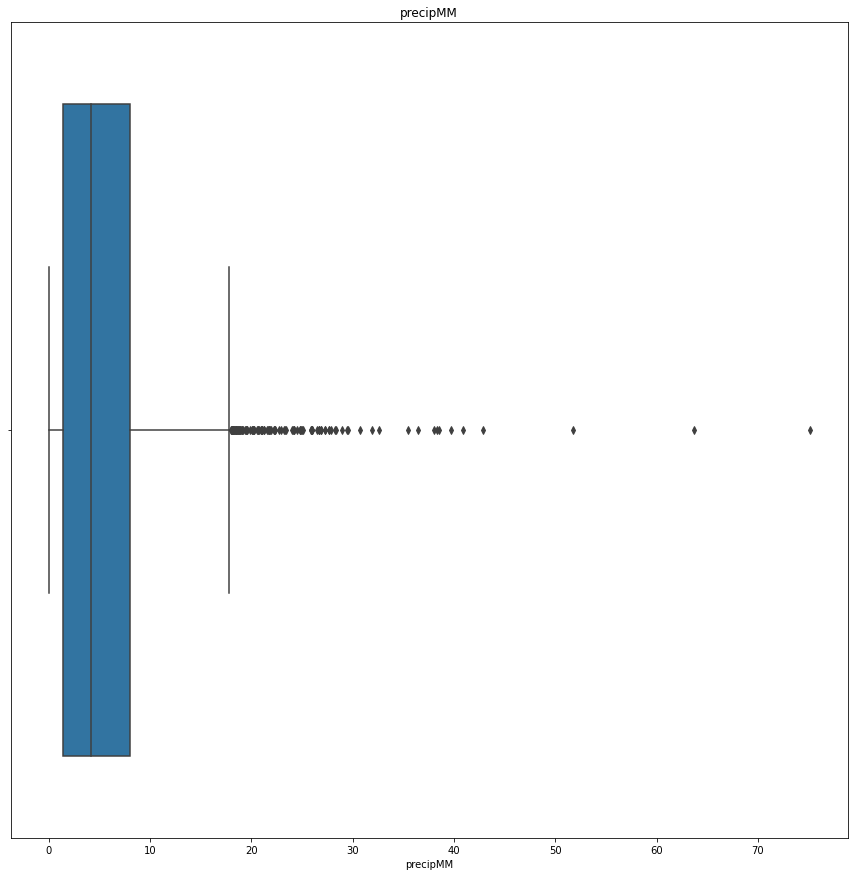

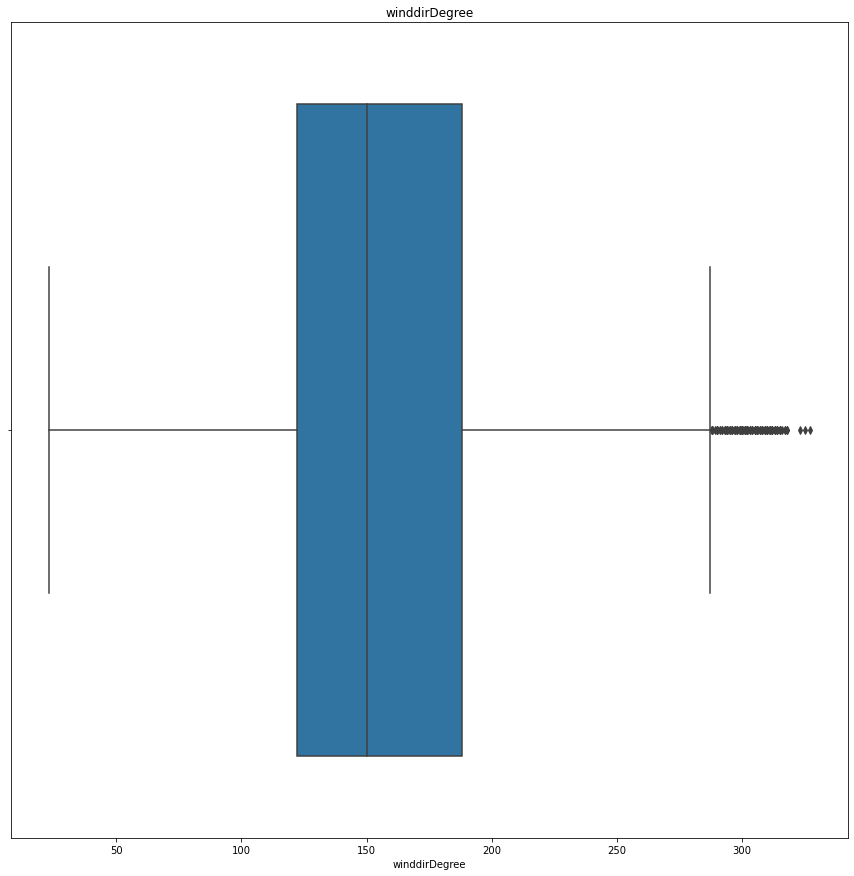

<Figure size 1080x1080 with 0 Axes>

In [44]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

Although in general we will be either removing the outlier, or utilize standard deviation to normalize the data, as we are working with weather data, there will be certain occasions where the precipitation and humidity are at its highest and vice-versa. Therefore the values will be kept instead to assist with the forecasting.

## Looking at temperature data for the past 10 years

#### Preparing the average temperature (temp) vs time (date_time) dataset

In this part of the analysis, the data from the average temperature is compared with the date to create a 10-year daily average temperature graph. Plotting a time-series graph will assist with identifying the trend, seasonal cycles and outliers.

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date_time, y=df['tempC'], name='Average Temperature',line_color='green'))
fig.layout.update(title_text='Time Series of Average Temperature with Rangeslider',xaxis_rangeslider_visible=True)

Layout({
    'template': '...',
    'title': {'text': 'Time Series of Average Temperature with Rangeslider'},
    'xaxis': {'rangeslider': {'visible': True}}
})

In [17]:
fig.show(renderer="browser")

It can be observed that the trend in temperature over time as well as the monthly and yearly seasonal pattern based on the temperature. These patterns will be visible again once the forecast model has been deployed later on.

In [25]:
X = df[['date_time', 'maxtempC']]
y = df.iloc[:,1]

In [26]:
train_df = pd.DataFrame()
train_df['ds'] = pd.to_datetime(X['date_time'])
train_df['y']=y

In [27]:
train_df.head(10)

,ds,y
0,2012-03-08,32
1,2012-03-09,33
2,2012-03-10,32
3,2012-03-11,31
4,2012-03-12,26
5,2012-03-13,32
6,2012-03-14,34
7,2012-03-15,33
8,2012-03-16,36
9,2012-03-17,33


#### Training the model

The model is trained for a period of 365 days (1 year) from the latest data input given.

In [28]:
model = Prophet()
model.fit(train_df)
future_temp = model.make_future_dataframe(periods=365)
future_temp.tail(2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
4016,2023-03-07
4017,2023-03-08


#### Saving and loading the model for future use

In [29]:
with open('saved_model_temp.pkl', "wb") as f:
    pickle.dump(model, f)

In [30]:
with open('saved_model_temp.pkl', "rb") as f:
    m_temp = pickle.load(f)

#### Rendering and viewing the forecast

In [31]:
forecast_temp = m_temp.predict(future_temp)
fig_temp = plot_plotly(m_temp, forecast_temp)

In [32]:
fig_temp.show(renderer="browser")

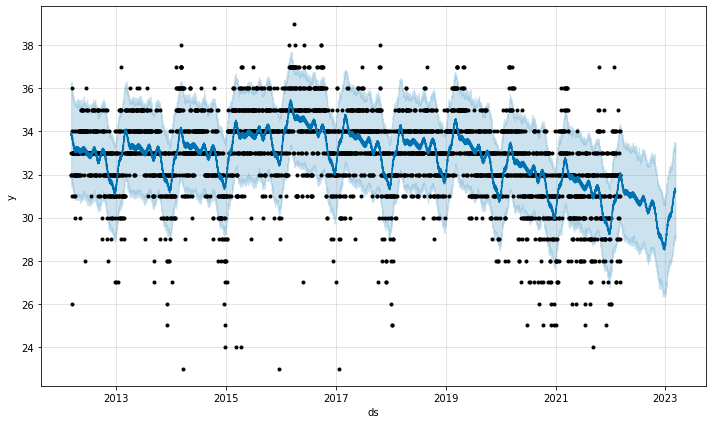

In [33]:
# To render the forecasted graph on jupyter
plot_temp = m_temp.plot(forecast_temp)

Looking at the one year forecasted temperature graph from March 9, 2022 onwards, it can be concluded that the average temperature is much lower as compared to the years before, but the monthly and daily temperature fluctuates similarly when compared from month-to-month or day-to-day, noting that there is some common attributes for the temperature's trend.

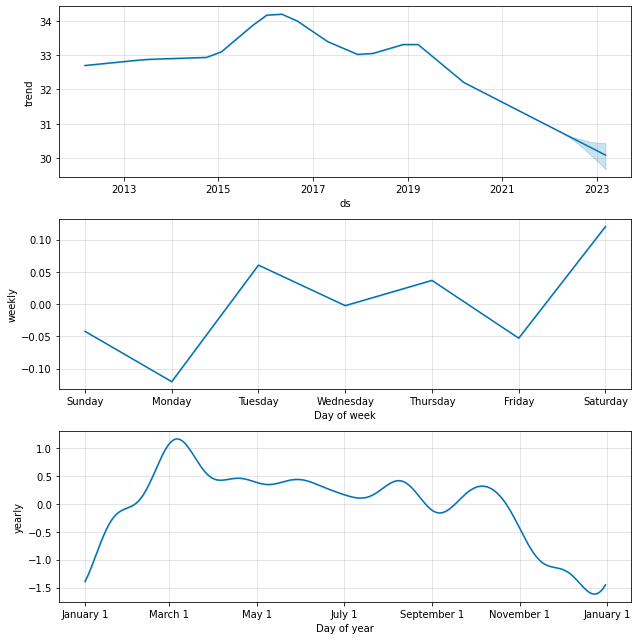

In [234]:
#plot component wise forecast
fig2_temp = m_temp.plot_components(forecast_temp)

Based on the forecast graph created above, it can be concluded that there is a downward trend when it comes to the average daily temperature, while looking at the weekly plot, the temperature is at it's highest usually on a weekend in Kuala Lumpur. Moving to the yearly plot, it can be observed that the temperature has a downward trend from March 1 onwards, potentially because of frequent raining happening over the few months period.

## Looking at precipitation data over the 10 years

#### Preparing the precipitation (precipMM) vs time (date_time) dataset

Similarly to the analysis done before, the data from the daily precipitation is compared with the date to create a 10-year daily precipitation graph.

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date_time, y=df['precipMM'], name='Precipitation in MM',line_color='green'))
fig.layout.update(title_text='Time Series of Daily Precipitation with Rangeslider',xaxis_rangeslider_visible=True)

Layout({
    'template': '...',
    'title': {'text': 'Time Series of Daily Precipitation with Rangeslider'},
    'xaxis': {'rangeslider': {'visible': True}}
})

In [19]:
fig.show(renderer="browser")

It is worth noting, based on the observation done on the Time Series of Daily Precipitation with Rangeslider that there are a couple of spikes, on April 24, 2020 and April 28, 2021. Based on a simple search online, it can be seen that there were floods happening around the aforementioned dates, namely the [16 April 2020 Flash Flood](https://www.bharian.com.my/berita/kes/2020/04/678066/lebih-20-kenderaan-ditenggelami-banjir-kilat) and the [Heavy Rain and Flash Flood in KL in April 2021](https://www.bharian.com.my/berita/nasional/2021/04/806827/ribut-petir-di-kl-hingga-sabtu) respectively.

In [35]:
X1 = df[['date_time', 'precipMM']]
y1 = df.iloc[:,17]

In [36]:
train_df1 = pd.DataFrame()
train_df1['ds'] = pd.to_datetime(X1['date_time'])
train_df1['y']=y1

In [37]:
train_df1.head(10)

,ds,y
0,2012-03-08,4.1
1,2012-03-09,4.1
2,2012-03-10,6.3
3,2012-03-11,8.3
4,2012-03-12,5.0
5,2012-03-13,1.1
6,2012-03-14,2.1
7,2012-03-15,4.2
8,2012-03-16,3.9
9,2012-03-17,6.7


#### Training the model

The model is trained for a period of 365 days (1 year) from the latest data input given.

In [38]:
model = Prophet()
model.fit(train_df1)
future_prec = model.make_future_dataframe(periods=365)
future_prec.tail(2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
4016,2023-03-07
4017,2023-03-08


In [39]:
with open('saved_model_prec.pkl', "wb") as f:
    pickle.dump(model, f)

In [40]:
with open('saved_model_prec.pkl', "rb") as f:
    m_prec = pickle.load(f)

#### Rendering and viewing the forecast

In [41]:
forecast_prec = m_prec.predict(future_prec)
fig_prec = plot_plotly(m_prec, forecast_prec)

In [42]:
fig_prec.show(renderer="browser")

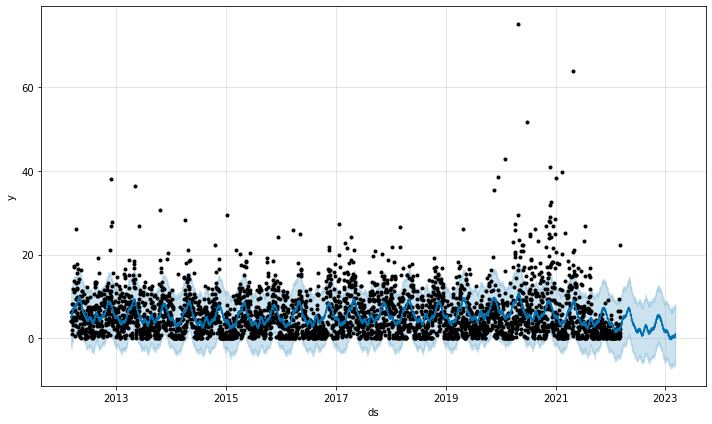

In [43]:
plot_prec = m_prec.plot(forecast_prec)

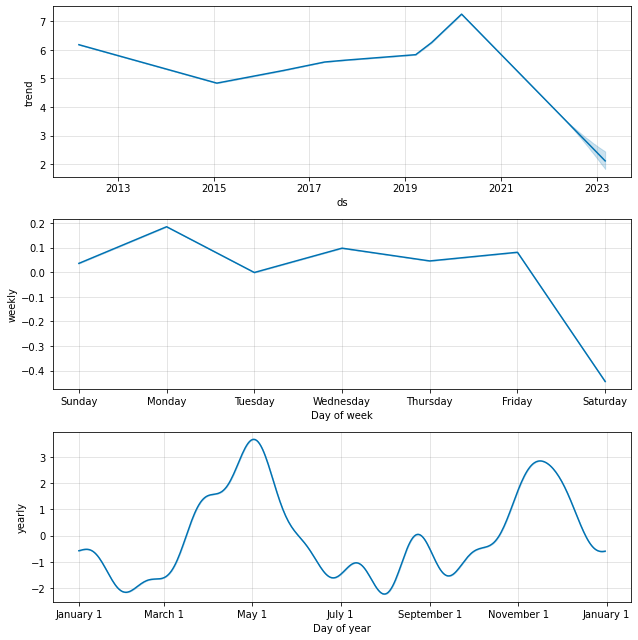

In [245]:
#plot component wise forecast
fig2_prec = m_prec.plot_components(forecast_prec)

Similar to the output plot from the previous model, wecan see a steep decline of precipitation when compared to the years prior to 2020, potentially due to lesser rainfalls. Lesser precipitation can also be seen on Saturdays, while the highest precipitation can be observed between April and June, and also November and January.

These observations are aligned with the forecast temperature graph, which means that temperature and precipitation are inversely related to one another.

In [5]:
pip install meteogram-py

  Using cached meteogram-py-0.0.1.tar.gz (3.0 kB)
  Created wheel for meteogram-py: filename=meteogram_py-0.0.1-py3-none-any.whl size=3509 sha256=7b21dbea3ca7e70fcddbaf4f31ae6279115df751a4b0e3e14a47fb63465d43c3
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\41\b8\02\6a8e919e6719a91d496748af6531e68f450c8b3a3180027940
Successfully built meteogram-py
Note: you may need to restart the kernel to use updated packages.


In [11]:
from datetime import datetime, timedelta
from meteogrampy import Meteogram, SubPlot
from meteogrampy.styles import Temperature, WindSpeed, WindDirection, Freezing

SyntaxError: invalid syntax (__init__.py, line 10)

In [9]:


temperature_data = [50, 49, 18, 17, 18, 18, 19]
wind_speed_data = [10, 25, 26, 30, 25, 26, 28]
wind_direction_data = [180, 345, 355, 1, 355, 354, 356]

dates = []
date = datetime(2016, 12, 25, 12, 0)
dates.append(date)
for x in xrange(len(temperature_data) - 1):
    date = date + timedelta(seconds=3600)
    dates.append(date)


freezing_data = [32 for x in dates]

temp = Meteogram.variable(Temperature, [dates, temperature_data])
freezing = Meteogram.variable(Freezing, [dates, freezing_data])
wind_speed = Meteogram.variable(WindSpeed, [dates, wind_speed_data])
wind_direction = Meteogram.variable(WindDirection, [dates, wind_direction_data])


temp_plot = SubPlot(left_vars=(temp, freezing))


wind_plot = SubPlot(left_vars=wind_speed, right_var=wind_direction)
wind_plot.right_ylim = (0, 360)

meteogram = Meteogram((wind_plot, temp_plot))
meteogram.title = "Sweet data bro!"
meteogram.show()

SyntaxError: invalid syntax (__init__.py, line 10)